In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, os
import cv2
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, Sequential, models, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from tqdm import tqdm

# Setup

 You can upgrade your notebook's GPU settings in Runtime > Change runtime type in the menu to select from several accelerator options, subject to availability.

 Note: The T4 GPU is 16GB, if you need more the A100 is a monster if you use Colab Pro. Also you should switch to high RAM.

In [2]:
# you can get Colab Pro with student email. I crashed due to a memory error so I ended up doing that
# this will check to make sure you are using a gpu

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 25 19:53:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# this is to make sure tensorflow sees it
print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# I enable memory growth so that the GPU memory will be allocated only for what is needed for the runtime
# basically starts out small and if program asks for me it will give
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found.")

Enabled memory growth for 1 GPU(s).


In [5]:
# this is for checking how much RAM you have available
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# Data Prep
- Load data from kaggle (use your API key)
- Check that all images are uniform size and normalized to [0,1]
- Organize into train/val/test folders

Go to this link if need to setup the API https://www.kaggle.com/docs/api

In [6]:
# ensure kaggle is installed
! pip install -q kaggle

In [7]:
# use the API key for kaggle (kaggle.json)
# usually downloads onto your drive with the OS installed. example) C:\Users\Kian\.kaggle\kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kiankm","key":"d2f4bf5e510e16ead02c32575a1e8e05"}'}

In [8]:
import kagglehub
path = kagglehub.dataset_download("andrewmvd/medical-mnist")

print("Path to dataset files:", path)

# if correct, should output "Path to dataset files: /kaggle/input/medical-mnist"

Using Colab cache for faster access to the 'medical-mnist' dataset.
Path to dataset files: /kaggle/input/medical-mnist


In [9]:
# Need to change working directory from colab default
# Get the current working directory to see where we are
print(f"Current working directory: {os.getcwd()}")

# Change the working directory to the path where our data will go
os.chdir('/kaggle/input')

# Verify the change
print(f"New working directory: {os.getcwd()}")

Current working directory: /content
New working directory: /kaggle/input


In [10]:
class_names = ['AbdomenCT','BreastMRI','CXR','ChestCT','Hand','HeadCT'] #6 classes for this data
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

n_classes = len(class_names)

IMAGE_SIZE = (64, 64) # this is the size listed in the description on kaggle

In [15]:
def load_data(dataset="medical-mnist"):
    images = []
    labels = []

    print(f"Loading {dataset}")

    # Iterate through each folder corresponding to a category
    for folder in os.listdir(dataset):
        folder_path = os.path.join(dataset, folder)
        if not os.path.isdir(folder_path):
            continue  # skip non-folder entries if any

        label = class_names_label[folder]

        # Iterate through each image in the folder
        for file in tqdm(os.listdir(folder_path), desc=f"Folder: {folder}"):
            img_path = os.path.join(folder_path, file)

            # Read and preprocess image
            image = cv2.imread(img_path)
            if image is None:
                continue  # skip bad reads if any

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)

            images.append(image)
            labels.append(label)

    # Convert to NumPy arrays
    images = np.array(images, dtype=np.float32) / 255.0   # normalize
    labels = np.array(labels, dtype=np.int32)

    return images, labels


In [16]:
X, y = load_data()
print(type(X), X.shape)  # <class 'numpy.ndarray'> (N, H, W, 3)
print(type(y), y.shape)  # <class 'numpy.ndarray'> (N,)

Loading medical-mnist


Folder: ChestCT: 100%|██████████| 10000/10000 [00:09<00:00, 1070.09it/s]


<class 'numpy.ndarray'> (58954, 64, 64, 3)
<class 'numpy.ndarray'> (58954,)


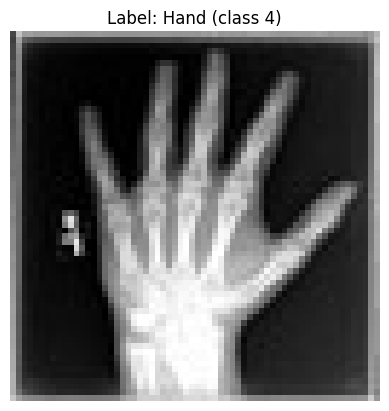

In [33]:
# just for selecting random image to view if you want to get a better idea of the data
i = np.random.randint(len(X))  # random valid index

img = X[i]
label_idx = y[i]
label_name = class_names[label_idx]

plt.imshow(img)
plt.title(f"Label: {label_name} (class {label_idx})")
plt.axis("off")
plt.show()

In [29]:
from sklearn.model_selection import train_test_split

# now we split into train/val/test
# X, y are the full arrays
print(X.shape, y.shape)  # should be (58954, 64, 64, 3), (58954,)

#Train / Test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y    # keep class distribution the same in train and test, we can check this in next block
)

# From the train split, make Train / Val (80/20 of train)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:  ", X_val.shape, y_val.shape)
print("Test shape: ", X_test.shape, y_test.shape)

(58954, 64, 64, 3) (58954,)
Train shape: (37730, 64, 64, 3) (37730,)
Val shape:   (9433, 64, 64, 3) (9433,)
Test shape:  (11791, 64, 64, 3) (11791,)


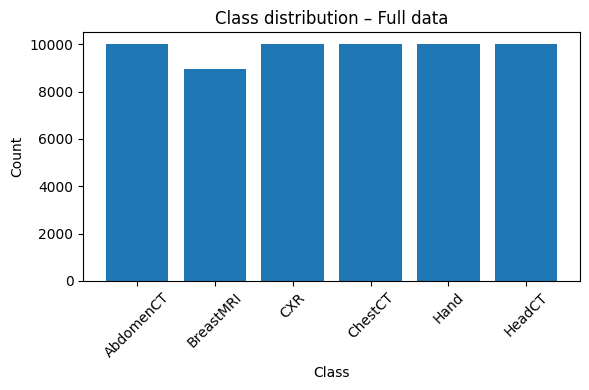

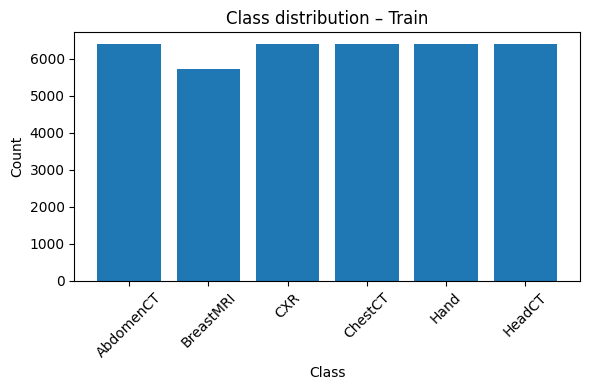

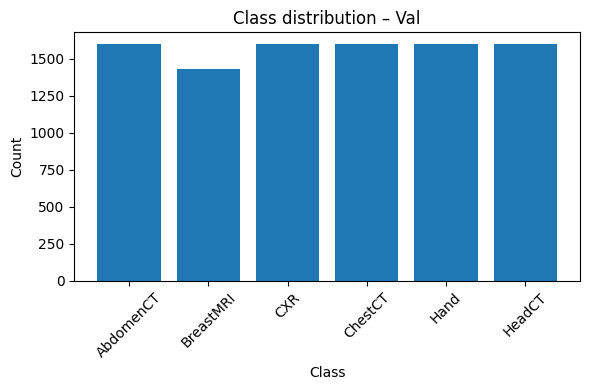

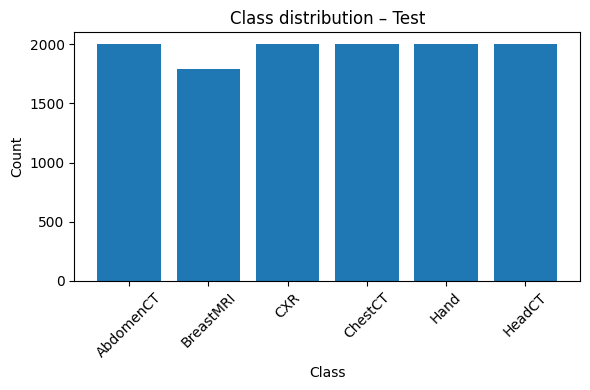

In [30]:
#just a helper func to get the clas distributions going
def plot_class_distribution(y, title):
    counts = np.bincount(y, minlength=n_classes)

    plt.figure(figsize=(6, 4))
    plt.bar(np.arange(n_classes), counts)
    plt.xticks(np.arange(n_classes), class_names, rotation=45)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Full dataset
plot_class_distribution(y, "Class distribution – Full data")

# Train
plot_class_distribution(y_train, "Class distribution – Train")

# Validation
plot_class_distribution(y_val, "Class distribution – Val")

# Test
plot_class_distribution(y_test, "Class distribution – Test")


## Comments
Distributions look pretty even across the board. Now that the data is prepped we can start building the model

# Model Building
- First we will make a preliminary CNN model to see how it performs
- Then we can start doing hyper param searching, will be a random search over a field of options we define
- We should be tracking validation acc and AUC as metrics, then presenting top 10 or so best models by those metrics
- Using the best model config, we then train a new model on the full train data (train+val) and test it on test set, record the acc and AUC
- At this point we are pretty much done, just need to get confusion matrix and plot showing ROC curves


Additional tip: use early stopping criteron , show train/val acc and loss plots

In [43]:
from tensorflow.keras.utils import to_categorical
# we will one hot encode thew categoricals as we will use categorical cross entropy as loss func
y_train_oh = to_categorical(y_train, num_classes=6)
y_val_oh   = to_categorical(y_val, num_classes=6)
y_test_oh = to_categorical(y_test, num_classes=6)

In [44]:
# very basic model, make new function later to make hyperparams adjustable
def build_cnn_model(input_shape=(64, 64, 3), num_classes=6):

    model = models.Sequential()

    # model base
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))
    loss = 'categorical_crossentropy'

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=loss,
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    return model

In [45]:
model = build_cnn_model(input_shape=(64, 64, 3), num_classes=6)

history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=20,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=3, verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )
    ]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8921 - auc: 0.9801 - loss: 0.2992 - val_accuracy: 0.9963 - val_auc: 0.9997 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 2/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9963 - auc: 0.9997 - loss: 0.0150 - val_accuracy: 0.9987 - val_auc: 0.9999 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 3/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9972 - auc: 0.9999 - loss: 0.0089 - val_accuracy: 0.9977 - val_auc: 0.9996 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 4/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9982 - auc: 0.9999 - loss: 0.0071 - val_accuracy: 0.9987 - val_auc: 0.9998 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 5/20
586/590 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9990 - auc: 1.0000 - loss: 0.0033
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9990 - auc: 1.0000 - loss:

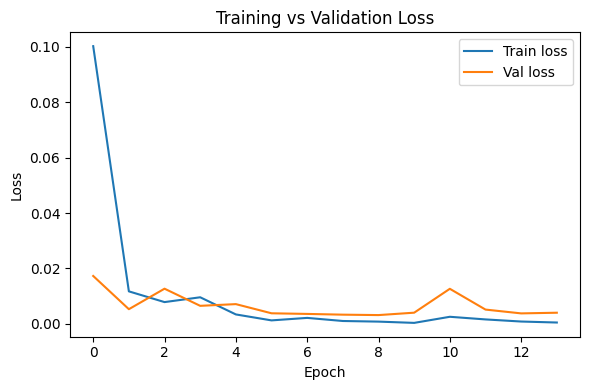

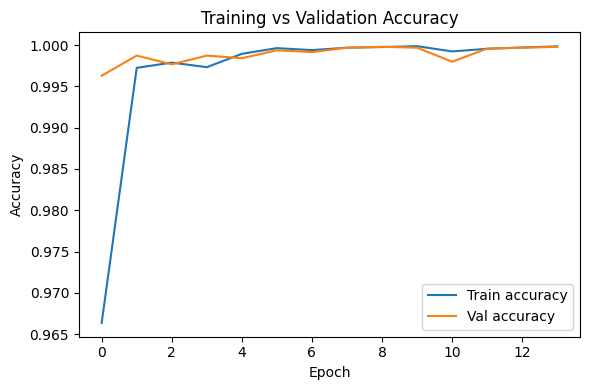

In [46]:
# helper func to show acc and loss curves
def plot_training_history(history):
    history_dict = history.history

    # loss
    plt.figure(figsize=(6, 4))
    plt.plot(history_dict['loss'], label='Train loss')
    plt.plot(history_dict['val_loss'], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # accuracy

    acc_key = 'accuracy'
    val_acc_key = 'val_accuracy'

    plt.figure(figsize=(6, 4))
    plt.plot(history_dict[acc_key], label='Train accuracy')
    plt.plot(history_dict[val_acc_key], label='Val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


# call after training:
plot_training_history(history)


## Comments
Validation accuracy is already so high after running through this basic model that we are just going to skip straight to testing it on the test set. Maybe can mess with hyperparams later, but lets take a look at results first.

In [49]:
model.summary() # this is to show what our model looks like

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,576,596 (25.09 MB)

 Trainable params: 2,192,198 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,384,398 (16.73 MB)

In [47]:
# Combine train + val data for final training
X_full_train = np.concatenate([X_train, X_val], axis=0)
y_full_train = np.concatenate([y_train_oh, y_val_oh], axis=0)

print("Full training shape:", X_full_train.shape)
print("Full labels shape:", y_full_train.shape)

Full training shape: (47163, 64, 64, 3)
Full labels shape: (47163, 6)


In [50]:
# Clear the GPU/TF memory pls, later if we do hyperparam searching it will go above this block so will want to clear it for sure
tf.keras.backend.clear_session()

best_model = build_cnn_model(input_shape=(64, 64, 3), num_classes=6)

best_history = model.fit(
    X_full_train, y_full_train,
    epochs=20,
    batch_size=64,
    validation_split=0.10,  # small split just to monitor overfitting
    shuffle=True,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9997 - auc: 1.0000 - loss: 7.3295e-04 - val_accuracy: 0.9996 - val_auc: 0.9997 - val_loss: 0.0070
Epoch 2/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 6.3090e-04 - val_accuracy: 0.9994 - val_auc: 0.9997 - val_loss: 0.0067
Epoch 3/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9991 - auc: 1.0000 - loss: 0.0022 - val_accuracy: 0.9994 - val_auc: 0.9997 - val_loss: 0.0067
Epoch 4/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.1331e-04 - val_accuracy: 0.9996 - val_auc: 0.9997 - val_loss: 0.0076
Epoch 5/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.7021e-04 - val_accuracy: 0.9996 - val_auc: 0.9997 - val_loss: 0.0082
Epoch 6/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9996 - auc: 1.0000 - loss: 0.0011 - val_accuracy: 0.9996 - val_auc: 0.9997 - val_loss: 0.0078
Epoch 7/20
664/66

In [54]:
test_loss, test_acc, test_auc  = best_model.evaluate(X_test, y_test_oh, verbose=1)

print("\n============ FINAL TEST RESULTS ============")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test AUC:      {test_auc:.4f}")
print("============================================")

369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1737 - auc: 0.5207 - loss: 1.7887

============ FINAL TEST RESULTS ============
Test Accuracy: 0.1729
Test Loss:     1.7891
Test AUC:      0.5202


In [52]:
# Setup for confusion matrix

y_probability = best_model.predict(X_test, batch_size=64) # will predict the class probs
y_pred = np.argmax(y_probability, axis=1) # will take the maximum probability for each example, then that becomes the predication
y_true = y_test # true labels, integer format

185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


<Figure size 800x600 with 0 Axes>

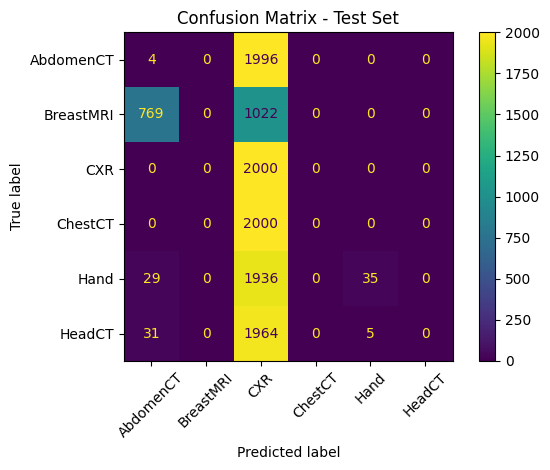

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# class name list in correct order
idx_to_class = {v: k for k, v in class_names_label.items()}
class_names = [idx_to_class[i] for i in range(n_classes)]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

## Comments
- So this is pretty innteresting, something is happening that caused the model to overfit while training and peerform reaelly badly on the test set. Not sure why its predicting CXR for almost everything... Will debut later. But this is pretty much all there is to it. Just reiterate and find best performing model for test set then create all the nice graphs and plots.

- I've put the code below for ROC curves and hyper param searching for later, first need to figure out what happened above

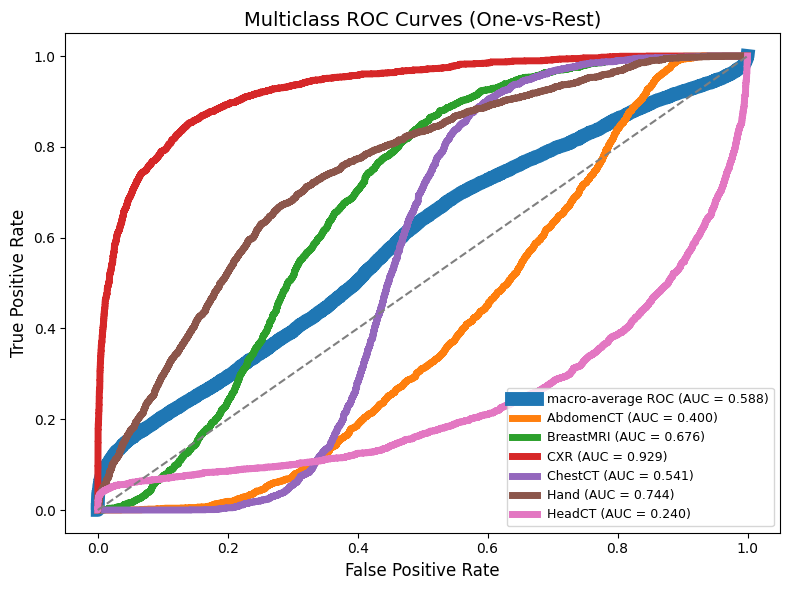

In [56]:
from sklearn.metrics import roc_curve, auc

# One-hot encode true labels for ROC
y_true_oh = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

# storage
fpr = {} # false pos rate
tpr = {} # true pos rate
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_oh[:, i], y_probability[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# average ROC across all classes, also called the macro average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Macro-average (thicker line)
plt.plot(
    all_fpr, mean_tpr,
    label=f"macro-average ROC (AUC = {roc_auc['macro']:.3f})",
    linewidth=10
)

# Per-class curves (slightly thinner than macro)
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i],
        label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})",
        linewidth=5
    )

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1.5)

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Multiclass ROC Curves (One-vs-Rest)", fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()


Below is a good way to view how the model is doing on different examples.

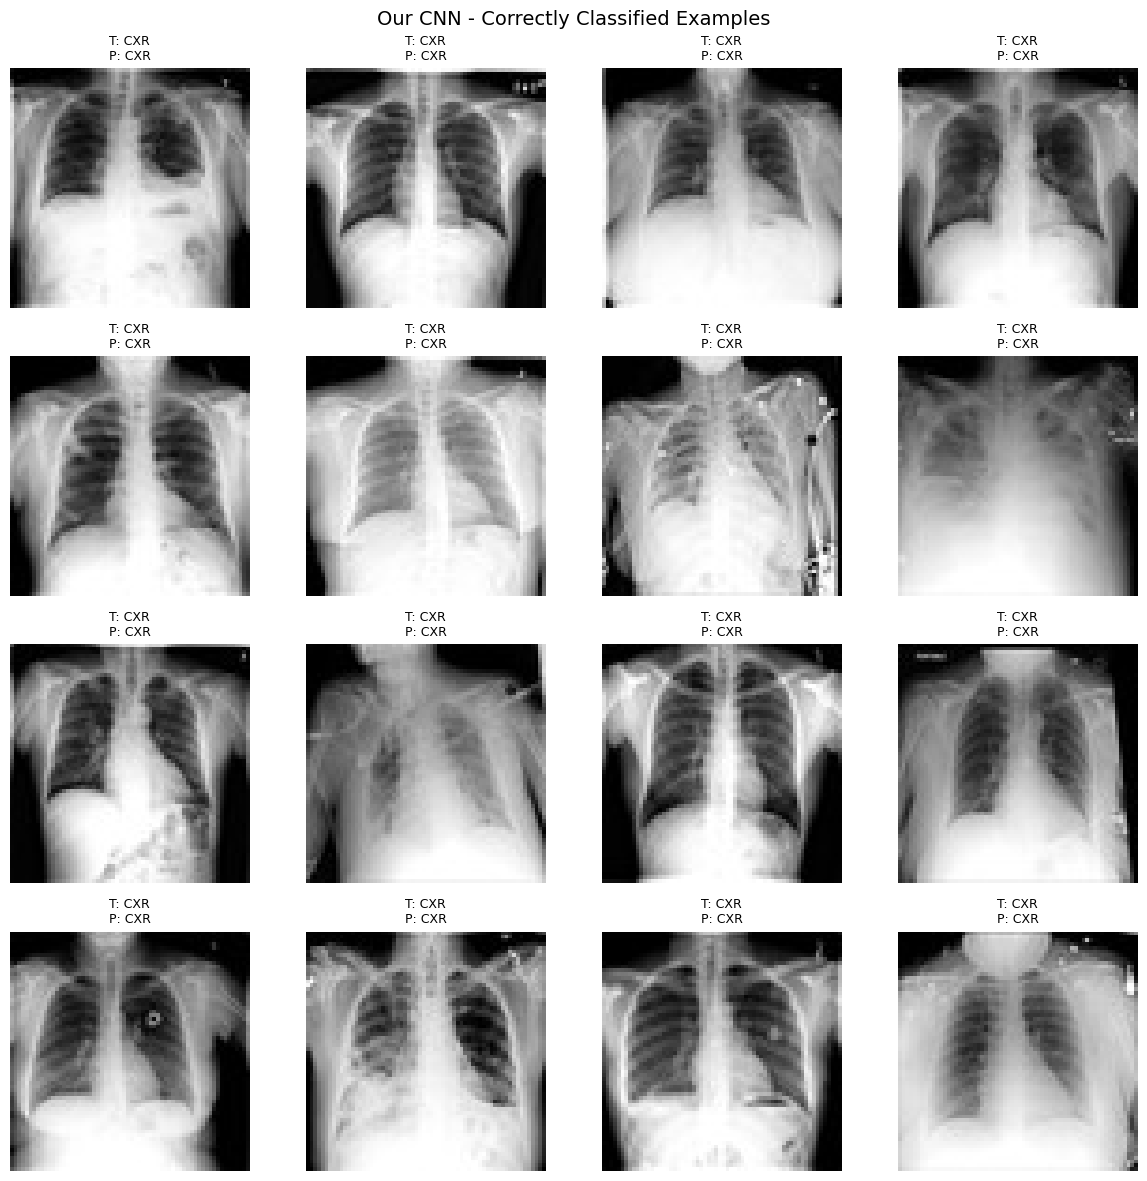

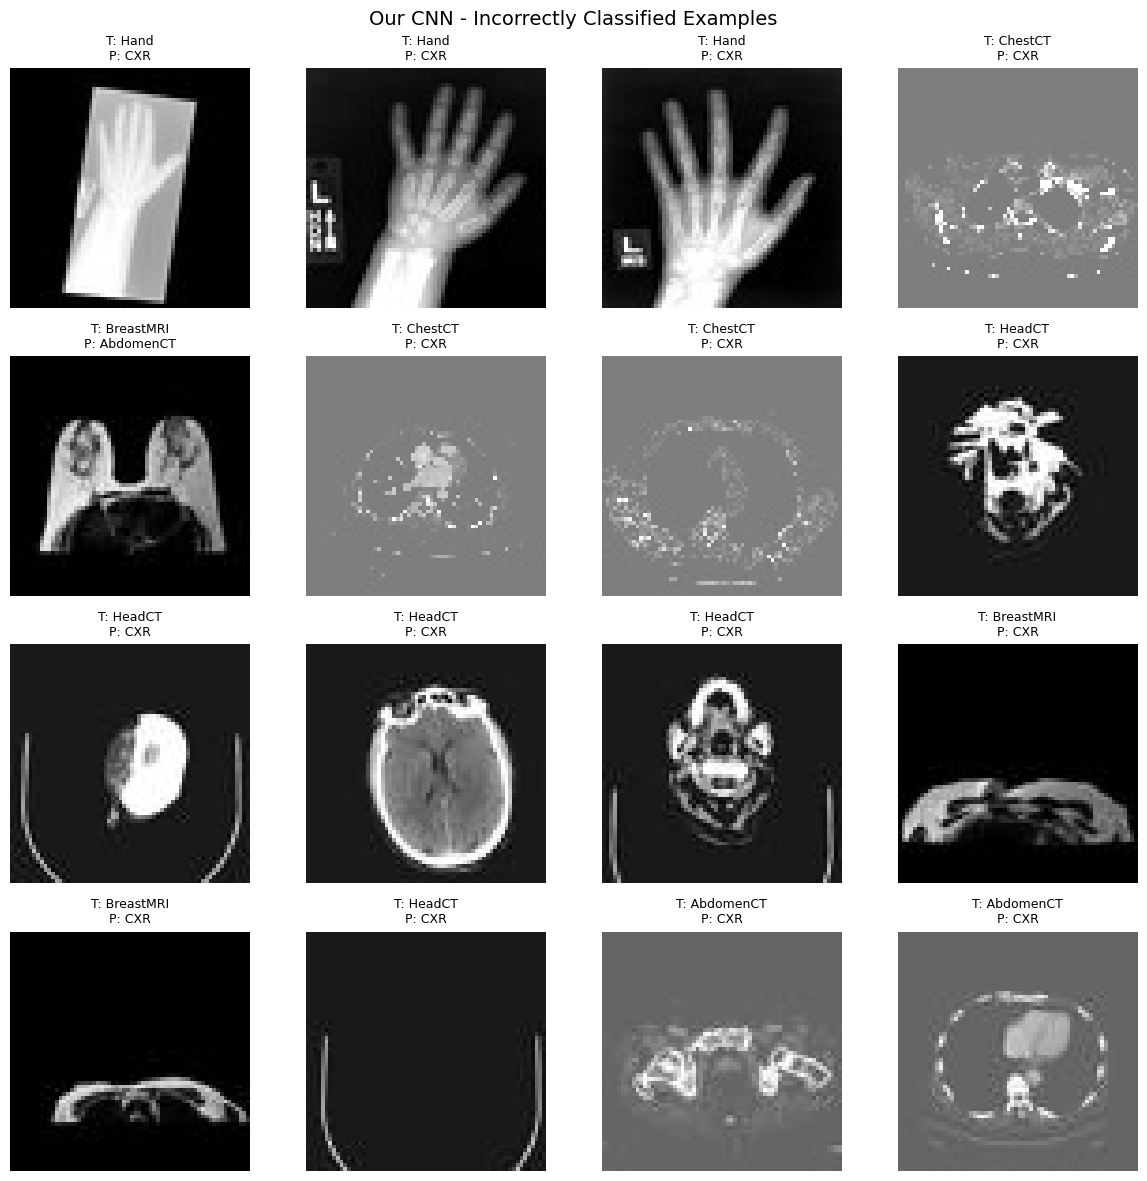

In [60]:
def get_predictions(model, images, batch_size=64):
    y_prob = model.predict(images, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    return y_prob, y_pred

def show_examples(y_true, y_pred, model_name, correct=True, max_images=16):
    if correct:
        idx = np.where(y_true == y_pred)[0]
        title = f"{model_name} - Correctly Classified Examples"
    else:
        idx = np.where(y_true != y_pred)[0]
        title = f"{model_name} - Incorrectly Classified Examples"

    if len(idx) == 0:
        print(f"No {'correct' if correct else 'incorrect'} examples found for {model_name}.")
        return

    # Shuffle indices so we don't always see the same class / first examples
    idx = np.random.permutation(idx)
    idx = idx[:max_images]

    n = len(idx)
    cols = 4
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(3*cols, 3*rows))
    for i, k in enumerate(idx):
        plt.subplot(rows, cols, i + 1)
        img = X_test[k]   # keep original images for visualization
        plt.imshow(img)
        true_label = class_names[y_true[k]]
        pred_label = class_names[y_pred[k]]
        plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=9)
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Baseline CNN
_, y_pred_best = get_predictions(best_model, X_test)
show_examples(y_test, y_pred_best, "Our CNN", correct=True)
show_examples(y_test, y_pred_best, "Our CNN", correct=False)

# Hyperparam stuff

- Below is code I wrote from a preevious project I did to show what hyperparameter searching might look like. We can reuse a lot of this later

In [ ]:
# use this one for hyperparam tuning
def build_cnn_from_params(input_shape, num_classes, hparams):
    """
    Build a CNN based on a hyperparameter dict.
    hparams keys: num_conv_blocks, base_filters, dense_units,
                  dropout_conv, dropout_dense, optimizer, learning_rate
    """
    model = models.Sequential()

    # CNN layers
    for i in range(hparams['num_conv_blocks']):
        filters = hparams['base_filters'] * (2 ** i)  # e.g., 32, 64, 128
        if i == 0:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu',
                                    padding='same', input_shape=input_shape))
        else:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))

        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(hparams['dropout_conv']))

    # classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(hparams['dense_units'], activation='relu'))
    model.add(layers.Dropout(hparams['dropout_dense']))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Optimizer selection
    lr = hparams['learning_rate']
    opt_name = hparams['optimizer'].lower()
    if opt_name == 'adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif opt_name == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=lr)
    elif opt_name == 'sgd':
        optimizer = optimizers.SGD(learning_rate=lr, momentum=0.9)
    else:
        raise ValueError(f"Unknown optimizer: {opt_name}")

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name="auc")] # added auc as metric
    )

    return model

# Expanded Hyperparameter Space
# # Expanded for broader search, avoiding low-performing LR (like 1e-2)
# and testing a 4-block CNN architecture.
param_space = {
    'num_conv_blocks': [2, 3, 4], # Added 4 blocks
    'base_filters': [32, 64],
    'dense_units': [64, 128, 256, 512], # Added 64
    'dropout_conv': [0.2, 0.25, 0.3, 0.4], # Refined to include 0.2
    'dropout_dense': [0.4, 0.5, 0.6], # Added 0.4
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'learning_rate': [1e-3, 5e-4, 1e-4, 5e-5, 1e-5], # Focus on smaller learning rates
    'batch_size': [32, 64]
}

def sample_hparams(space):
    """Randomly sample one combination from the param space."""
    return {k: random.choice(v) for k, v in space.items()}

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# store outputs here
checkpoint_path = "/kaggle/working/best_model.keras"

In [ ]:
#hyperparam tuning time!
N_TRIALS = 35          # change if you want
EPOCHS_PER_TRIAL = 25  # also changeable
PATIENCE = 3           # early stopping patience
tf.keras.backend.clear_session() # dont know why but having this here before it gets called in loop again fixes OOM error

input_shape = (150, 150, 3)

results = []

for trial in range(1, N_TRIALS + 1):
    print(f"\n===== Trial {trial}/{N_TRIALS} =====")

    # Clear previous model from memory
    tf.keras.backend.clear_session()

    # Sample hyperparameters
    hparams = sample_hparams(param_space)
    print("Hyperparameters:", hparams)

    # Build model
    model = build_cnn_from_params(input_shape, nb_classes, hparams)

    # Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )

    start_time = time.time()

    history = model.fit(
        X_train, y_train_oh,
        validation_data=(X_val, y_val_oh),
        epochs=EPOCHS_PER_TRIAL,
        batch_size=hparams['batch_size'],
        callbacks=[early_stop],
        verbose=1,
        shuffle=True
    )

    elapsed = time.time() - start_time

    # This will get best epoch based on val acc
    val_acc_history = history.history['val_accuracy']
    best_epoch_idx = int(np.argmax(val_acc_history))

    best_train_acc = history.history['accuracy'][best_epoch_idx]
    best_val_acc   = history.history['val_accuracy'][best_epoch_idx]
    best_train_loss = history.history['loss'][best_epoch_idx]
    best_val_loss   = history.history['val_loss'][best_epoch_idx]

    # !!!!NEW!!!!: AUC
    best_train_auc  = history.history['auc'][best_epoch_idx]
    best_val_auc    = history.history['val_auc'][best_epoch_idx]

    print(
        f"Best epoch: {best_epoch_idx+1} | "
        f"train_acc={best_train_acc:.4f}, val_acc={best_val_acc:.4f} | "
        f"train_auc={best_train_auc:.4f}, val_auc={best_val_auc:.4f}"
    )


    # Save trial result
    trial_result = {
        'trial': trial,
        'best_epoch': best_epoch_idx + 1,
        'train_acc': best_train_acc,
        'val_acc': best_val_acc,
        'train_loss': best_train_loss,
        'val_loss': best_val_loss,
        'train_auc': best_train_auc,   # NEW
        'val_auc': best_val_auc,       # NEW
        'time_sec': elapsed,
        # Hyperparams:
        **hparams
    }

    results.append(trial_result)

In [ ]:
df = pd.DataFrame(results)

# Sort by validation accuracy (descending)
df_sorted = df.sort_values('val_acc', ascending=False)

# Show top 10
top10 = df_sorted.head(10)
top10

In [ ]:
best_row = df_sorted.iloc[0]  # highest validation accuracy
best_hparams = {
    'num_conv_blocks': int(best_row['num_conv_blocks']),
    'base_filters': int(best_row['base_filters']),
    'dense_units': int(best_row['dense_units']),
    'dropout_conv': float(best_row['dropout_conv']),
    'dropout_dense': float(best_row['dropout_dense']),
    'optimizer': best_row['optimizer'],
    'learning_rate': float(best_row['learning_rate']),
    'batch_size': int(best_row['batch_size'])
}

print("Best hyperparameters:")
for k, v in best_hparams.items():
    print(f"  {k}: {v}")


### You would then re-train a new model using these parameters aftrward... ###